# Assignment 3. EDP-2023

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Supervision

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Writing - review & editing

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Visualization, Software, Writing - original draft

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

### Import libraries

In [258]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image
from sklearn.preprocessing import minmax_scale

pd.options.plotting.backend = 'plotly'

In [142]:
def random_walk(length: int, X_start: float, variance: float) -> np.array:
    noise = np.random.normal(loc = 0, scale = np.sqrt(variance), size = length)
    X = [X_start]
    for i in range(1, length):
        Xi = X[-1] + noise[i]
        X.append(Xi)
    return np.array(X)

def measurements(X: np.array, meas_variance: float = 15) -> np.array:
    noise = np.random.normal(loc = 0, scale = np.sqrt(meas_variance), size = len(X))
    return X + noise

def estimate_sigmas(measurements: np.array) -> [float, float]:
    vs = []
    ps = []
    N = len(measurements)
    for i in range(1, N):
        vs.append(measurements[i] - measurements[i-1])
        if i < 2:
            continue
        ps.append(measurements[i] - measurements[i-2])
    Ev = np.sum(np.array(vs)**2)/(N-1)
    Ep = np.sum(np.array(ps)**2)/(N-2)
    coefficients = np.array([[1, 2], [2, 2]])
    sigma_w, sigma_n = np.linalg.inv(coefficients)@np.array([Ev, Ep])
    return [sigma_w, sigma_n]

def optimal_alpha(sigma_w: float, sigma_n: float):
    xi = sigma_w / sigma_n
    alpha = (-xi+np.sqrt(xi**2+4*xi))/2
    return alpha

def exponential_smoothing(data: np.array, alpha: float, backward: bool = False) -> np.array:
    if not 0 < alpha < 1:
        raise ValueError("Alpha must be between 0 and 1.")
    smoothed_values = [data[0]]

    for t in range(1, len(data)):
        smoothed_value = smoothed_values[-1] + alpha * (data[t] - smoothed_values[-1])
        smoothed_values.append(smoothed_value)
    if backward:
        return exponential_smoothing(smoothed_values[::-1], alpha)[::-1]
    else:
        return smoothed_values

def running_mean(data: np.array, window_size: int) -> np.array:
    data_filtered = data.copy()
    for i in range(window_size//2+1, len(data)-window_size//2):
        window = slice(i - window_size//2 - 1, i + window_size//2)
        data_filtered[i] = sum(data[window])/window_size
    return np.array(data_filtered)

def running_mean_edgy(data: np.array, window_size: int) -> np.array:
    """Implementation of 'mirror' edge behaviour for rolling mean"""
    data_ = list(data)
    data_filtered_ext = np.array(data_[1:window_size//2 + 1][::-1] + data_ + data_[-window_size//2:-1][::-1])
    smoothed_data = []
    for i in range(len(data)):
        smoothed_data.append(sum(data_filtered_ext[i:i+window_size])/window_size)
    return np.array(smoothed_data)

def optimal_M(alpha: float) -> int:
    '''Calculates optimal moving window width'''
    return int(round((2-alpha)/alpha,0))

In [18]:
def trajectory(sample_size: int = 300, X1: float = 5, V1: float = 0, T: float = 0.1, variance: float = 10) -> np.array:
    '''Generates trajectory
    T is delta T'''
    # initialize values
    a = np.random.normal(0, np.sqrt(variance), sample_size)
    X, V = np.zeros((sample_size,)), np.zeros((sample_size,))
    X[0], V[0] = X1, V1

    # calculate trajectory
    for i in range(1, sample_size):
        V[i] = V[i-1] + a[i-1] * T
        X[i] = X[i-1] + V[i-1] * T + a[i-1]*(T**2)/2
    return X

def indicators(measurements: np.array, smoothed_data: np.array, print_: bool = False) -> (float, float):
    if len(measurements) != len(smoothed_data):
        raise ValueError(f"Unequal lengths of measurements {len(measurements)} and smoothed data {len(smoothed_data)}")
    MSE = ((measurements - smoothed_data)**2).mean()
    second_deriv = []
    for i in range(1, len(measurements) - 1):
        second_deriv.append(smoothed_data[i-1] + smoothed_data[i+1] - 2 * smoothed_data[i])
    Variability_ind = sum([x**2 for x in second_deriv]) / len(measurements)
    if print_:
        print(f"Mean squared error = {MSE:.1f}\nVariability indicator = {Variability_ind:.1f}")
        return None
    else:
        return MSE, Variability_ind

## First part: Backward exponential smoothing

In [267]:
fig = go.Figure()
sample_size = 3000
dispersion = 28**2
meas_dispersion = 97**2
x = np.arange(sample_size)
y_true = random_walk(sample_size, 10, dispersion)
y_meas = measurements(y_true, meas_dispersion)
alpha = optimal_alpha(*estimate_sigmas(y_meas))
window_size = optimal_M(alpha)
y_exp_smooth = exponential_smoothing(y_meas, alpha, True)
print("Backwards exponential smoothing indicators")
indicators(y_meas, y_exp_smooth, True)

y_run_mean = running_mean(y_meas, window_size)
print("\nRunning mean smoothing indicators")
indicators(y_meas, y_run_mean, True)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_true, name = 'true process', 
                         line_color = colors[0]))
fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'measurements', 
                         mode="markers",
                         marker_color = colors[2], marker_size = 4))
fig.add_trace(go.Scatter(x = x, y = y_exp_smooth, 
                         name = f'forward-backward exp<br>\u03b1 = {alpha:.3f}', 
                         line_color = colors[1]))
fig.add_trace(go.Scatter(x = x, y = y_run_mean, 
                         name = f'running mean<br>window_size = {window_size:d}', 
                         line_color = colors[4]))
fig.update_layout(template = 'simple_white', 
                  title = 'Random walk and smoothing methods',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0.8)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size-1],
                  width = 1150, height = 500)
fig.show()

Backwards exponential smoothing indicators
Mean squared error = 8255.7
Variability indicator = 50.5

Running mean smoothing indicators
Mean squared error = 8699.4
Variability indicator = 1116.1


In [260]:
fig.write_image(f"Random walk and smoothing methods_{sample_size}.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

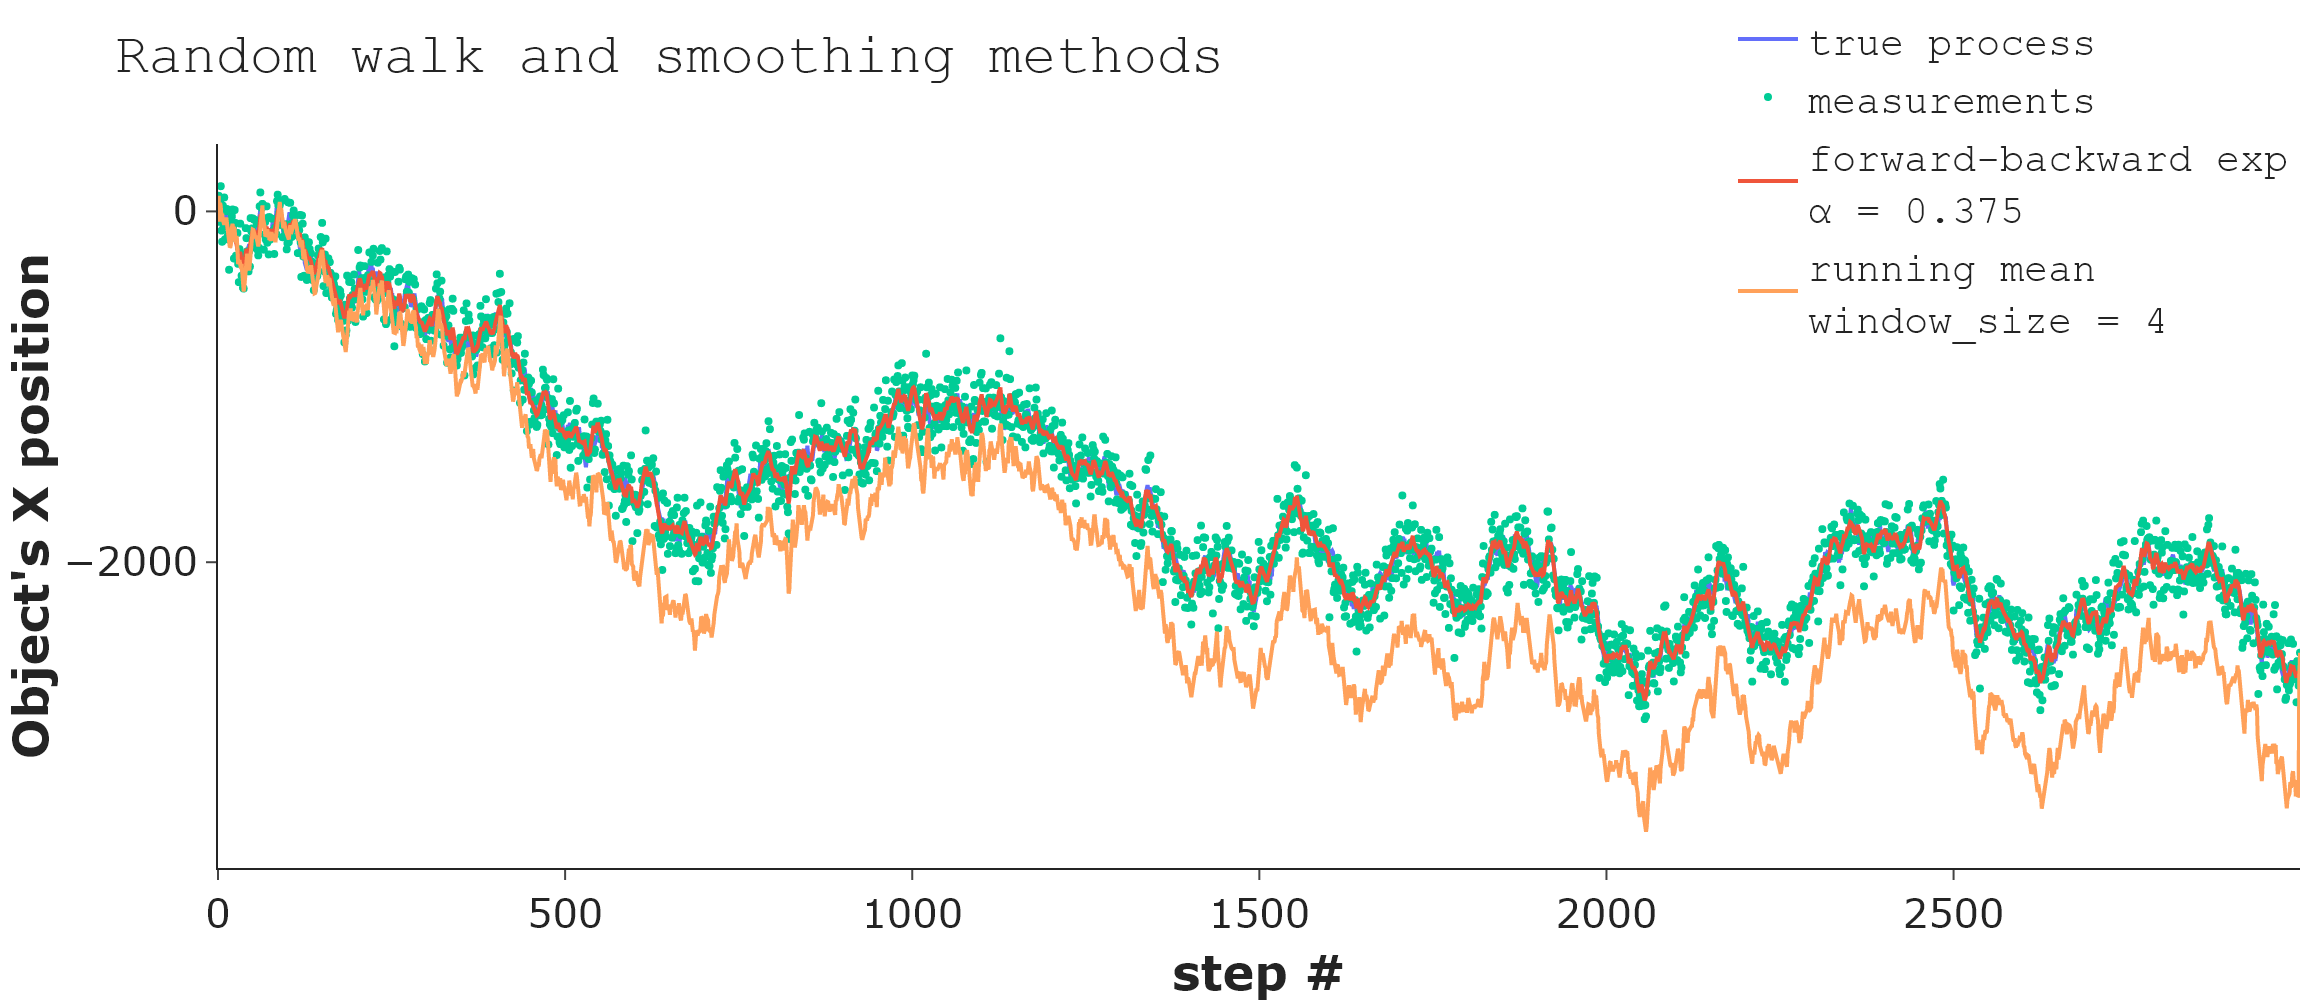

In [200]:
Image(f"Random walk and smoothing methods_3000.png")

Running mean smoothing leads to systematic error (orange line is shifted downwards from the blue line, which is almost completely covered by the red line),<br> 
especially if the measurement variance is large compared to process variance,<br>
<br>
While forward-backward smoothing does not produce such errors and overall seems like a nice fit without any shift

## Second part: Drawbacks of running mean

In [228]:
fig = go.Figure()
sample_size = 300
x = np.arange(sample_size)
y_true = trajectory(sample_size=sample_size)
y_meas = measurements(y_true, 500)
y_exp_smooth = exponential_smoothing(y_meas, 0.49, True)  
# optimal alpha value was calculated in the next cell by exhaustive search
# we supposed that MSE and Variability indicator are equally important parameters
print("Backwards exponential smoothing indicators")
indicators(y_meas, y_exp_smooth, True)

y_run_mean = running_mean_edgy(y_meas, 100)  
# optimal window_size was calculated in the next cell by exhaustive search and then we tried 
# to set the window_size according to our understanding of a "beautiful fit"
print("\nRunning mean smoothing indicators")
indicators(y_meas, y_run_mean, True)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_true, name = 'true process', line_color = colors[0]))
fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'measurements', 
                         mode="markers",
                         marker_color = colors[2], marker_size = 5))
fig.add_trace(go.Scatter(x = x, y = y_exp_smooth, 
                         name = f'forward-backward exp<br>\u03b1 = 0.49', line_color = colors[1]))
fig.add_trace(go.Scatter(x = x, y = y_run_mean, 
                         name = 'run mean', line_color = colors[4]))
fig.update_layout(template = 'simple_white', 
                  title = 'Trajectory #1 and smoothing methods',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0.8)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size-1],
                  width = 1150, height = 500)
fig.show()

Backwards exponential smoothing indicators
Mean squared error = 289.8
Variability indicator = 64.2

Running mean smoothing indicators
Mean squared error = 565.2
Variability indicator = 0.2


In [190]:
fig.write_image(f"Trajectory 1 and smoothing methods.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

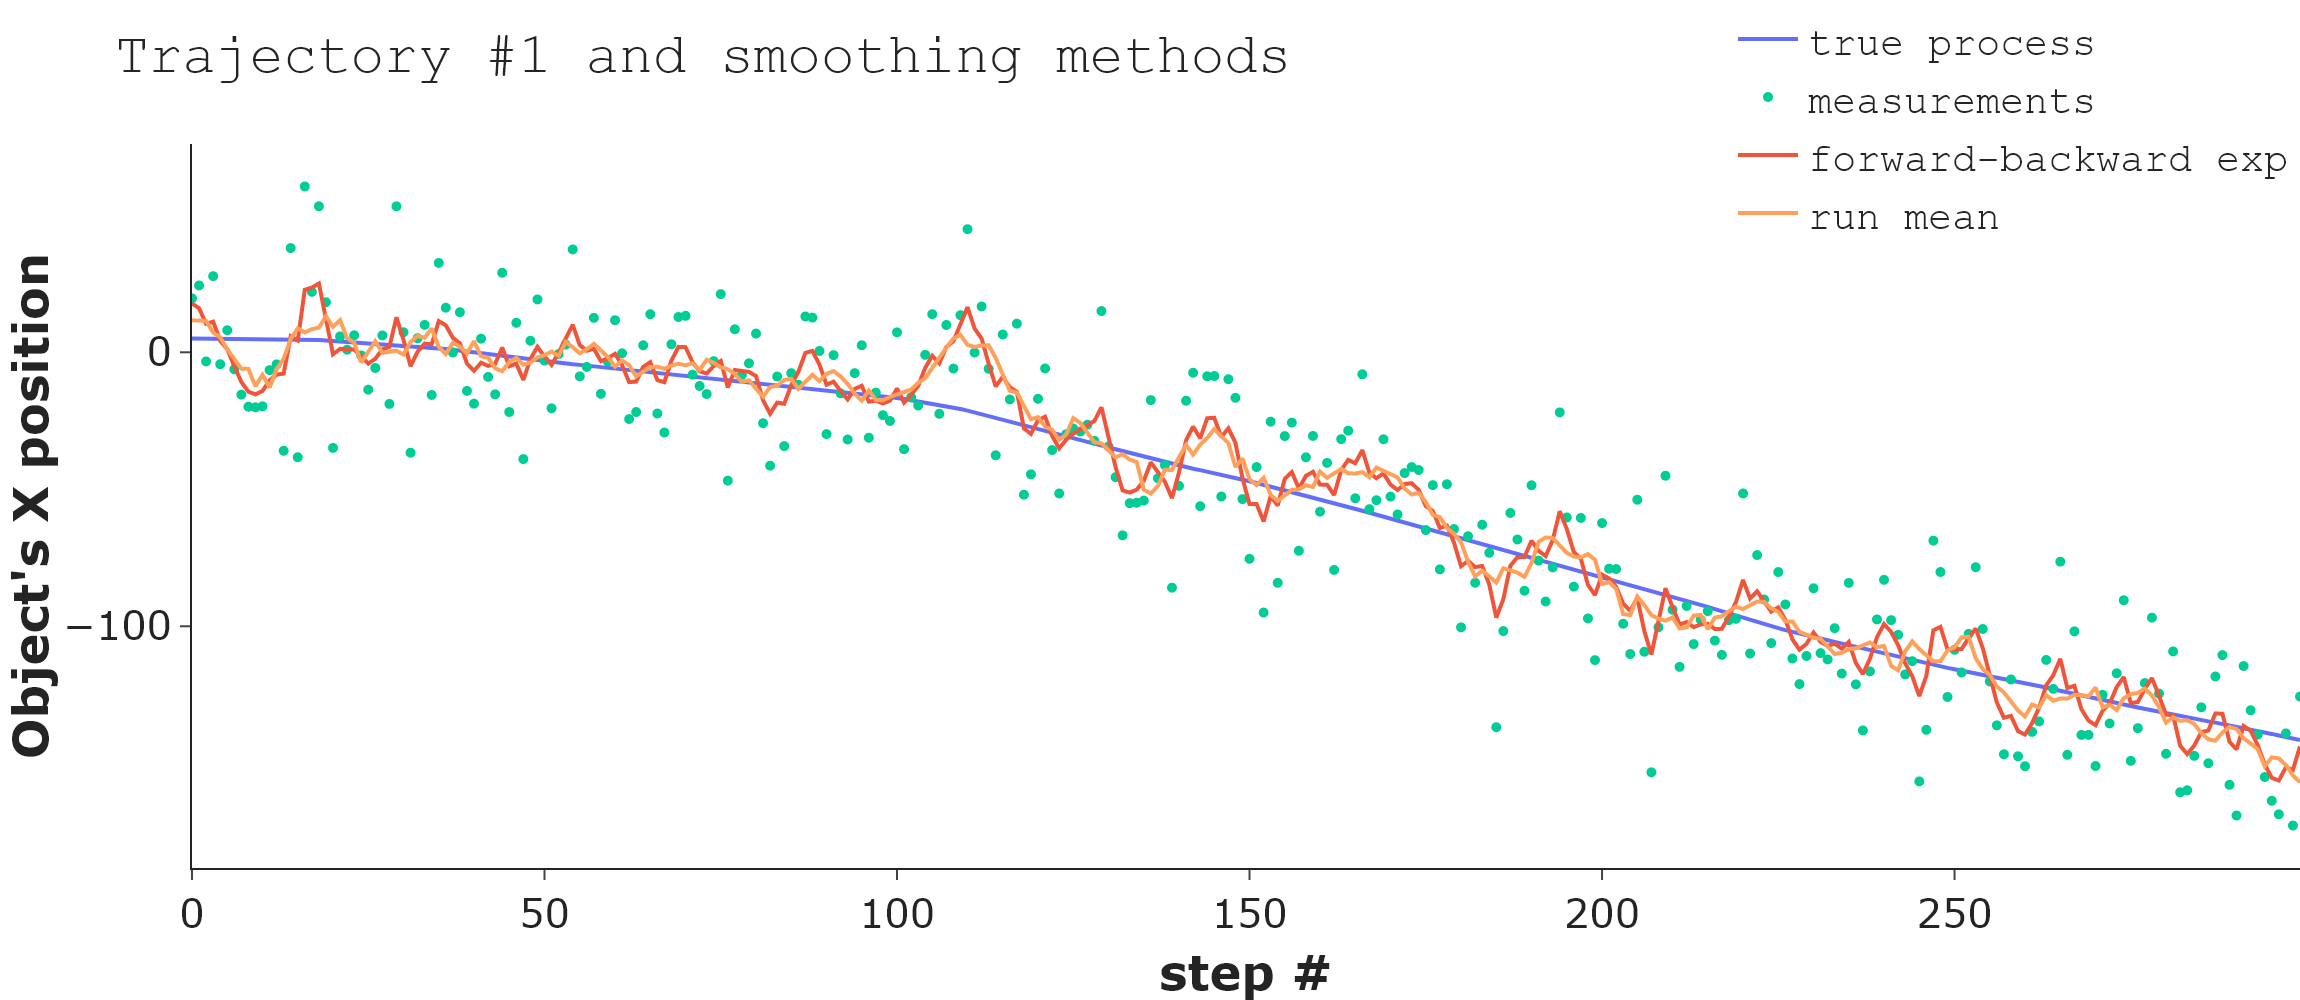

In [191]:
Image("Trajectory 1 and smoothing methods.png")

## Find optimal alpha by bruteforce

In [55]:
sample_size = 1000
x = np.arange(sample_size)
y_true = trajectory(sample_size)
y_meas = measurements(y_true, 500)
alphas = np.linspace(1e-8, 1, 1000, endpoint = False)
ind_df = []
for alpha in alphas:
    y_exp_smooth = exponential_smoothing(y_meas, alpha, True)
    ind_df.append(indicators(y_meas, y_exp_smooth))
ind_df = pd.DataFrame(data=ind_df, index=alphas, columns=["SE", "Variability indicator"])
ind_df = ind_df.assign(sum = ind_df.sum(axis = 1))
print(f"\u03b1|min(squared error + variability) = {ind_df['sum'].idxmin():.3f}")
ind_df.plot(height = 400)

α|min(squared error + variability) = 0.496


MSE (alpha) is a decreasing function, VarInd (alpha) is an increasing function.
optimal alpha is consistently between 0.47 and 0.51 regardless of the sample size, so we took 0.49 as the optimal alpha value

In [188]:
sample_size = 500
x = np.arange(sample_size)
y_true = trajectory(sample_size)
y_meas_ = measurements(y_true, 500)
window_sizes = np.arange(2, sample_size//4)
ind_df = []
for window_size in window_sizes:
    y_exp_smooth = running_mean_edgy(y_meas_, window_size)
    ind_df.append(indicators(y_meas_, y_exp_smooth))
ind_df = pd.DataFrame(data=ind_df, index=window_sizes, columns=["SE", "Variability indicator"])
ind_df = ind_df.assign(sum = ind_df.sum(axis = 1))
print(f"window size|min(squared error + variability) = {ind_df['sum'].idxmin():d}")
ind_df.plot(height = 400)

window size|min(squared error + variability) = 11


In [157]:
ind_df.SE.diff().plot()

We have implemented a 'mirror' edge behaviour for rolling mean (moving average) function in order to get consistent variability indicator values when doing the exhaustive search of the optimal value

MSE (window_size) is an increasing function but with several local extremums <br>
VarInd (window_size) is a decreasing function<br>

hence the window_size optimal value is not as stable as for alpha, it oscillates between 7 and 15 with occasional jumps to 30+<br>
Also we know, measurements variance compared to process variance is huge, so the truly optimal M is ~100, because MSE value for smoothing with this window_size is still lower than the original variance of 500


## Second trajectory

In [83]:
def trajectory2(size: int = 200, variance: float = 0.08**2, starting_position: int = 1, T: int = 32) -> np.array:
    A = [starting_position] 
    noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=size)
    omega = 2 * np.pi / T
    X = [starting_position * np.sin(omega + 3)]
    for i in range(1, size):
        X.append(A[-1] * np.sin(omega * (i + 1) + 3))
        A.append(A[-1] + noise[i])
    return np.array(X)

In [276]:
# adjust colors with sample colorscale
fig = go.Figure()
sample_size = 600  # default is 200
x = np.arange(sample_size)
y_true = trajectory2(sample_size, 0.08**2)
y_meas = measurements(y_true, 0.05)
colors = px.colors.qualitative.Plotly
window_sizes = [13,15,17,19,21,23,25,27]  # ,32,64,75
rm_colors = px.colors.sample_colorscale("Plasma", minmax_scale(window_sizes + [28]))
fig.add_trace(go.Scatter(x = x, y = y_true, name = 'true process', 
                         line_color = colors[0], line_width = 5))
fig.add_trace(go.Scatter(x = x, y = y_meas, 
                         name = 'measurements', mode="markers", 
                         marker_color = colors[2], marker_size = 5))
for i, M in enumerate(window_sizes):
    fig.add_trace(go.Scatter(x = x, y = running_mean_edgy(y_meas, M), name = f'window_size {M}', 
                             line_color = rm_colors[i]))

fig.update_layout(template = 'simple_white', 
                  title = 'Trajectory #2 and running means',
                  title_font_family = 'Courier',
                  font_size = 20,
                  legend_font_size = 15,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  xaxis_nticks = 5,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0.8)',
                  legend_x = 1,
                  legend_y = 1.2,
                  xaxis_range = [0,sample_size-1],
                  width = 1150, height = 500)
fig.show()

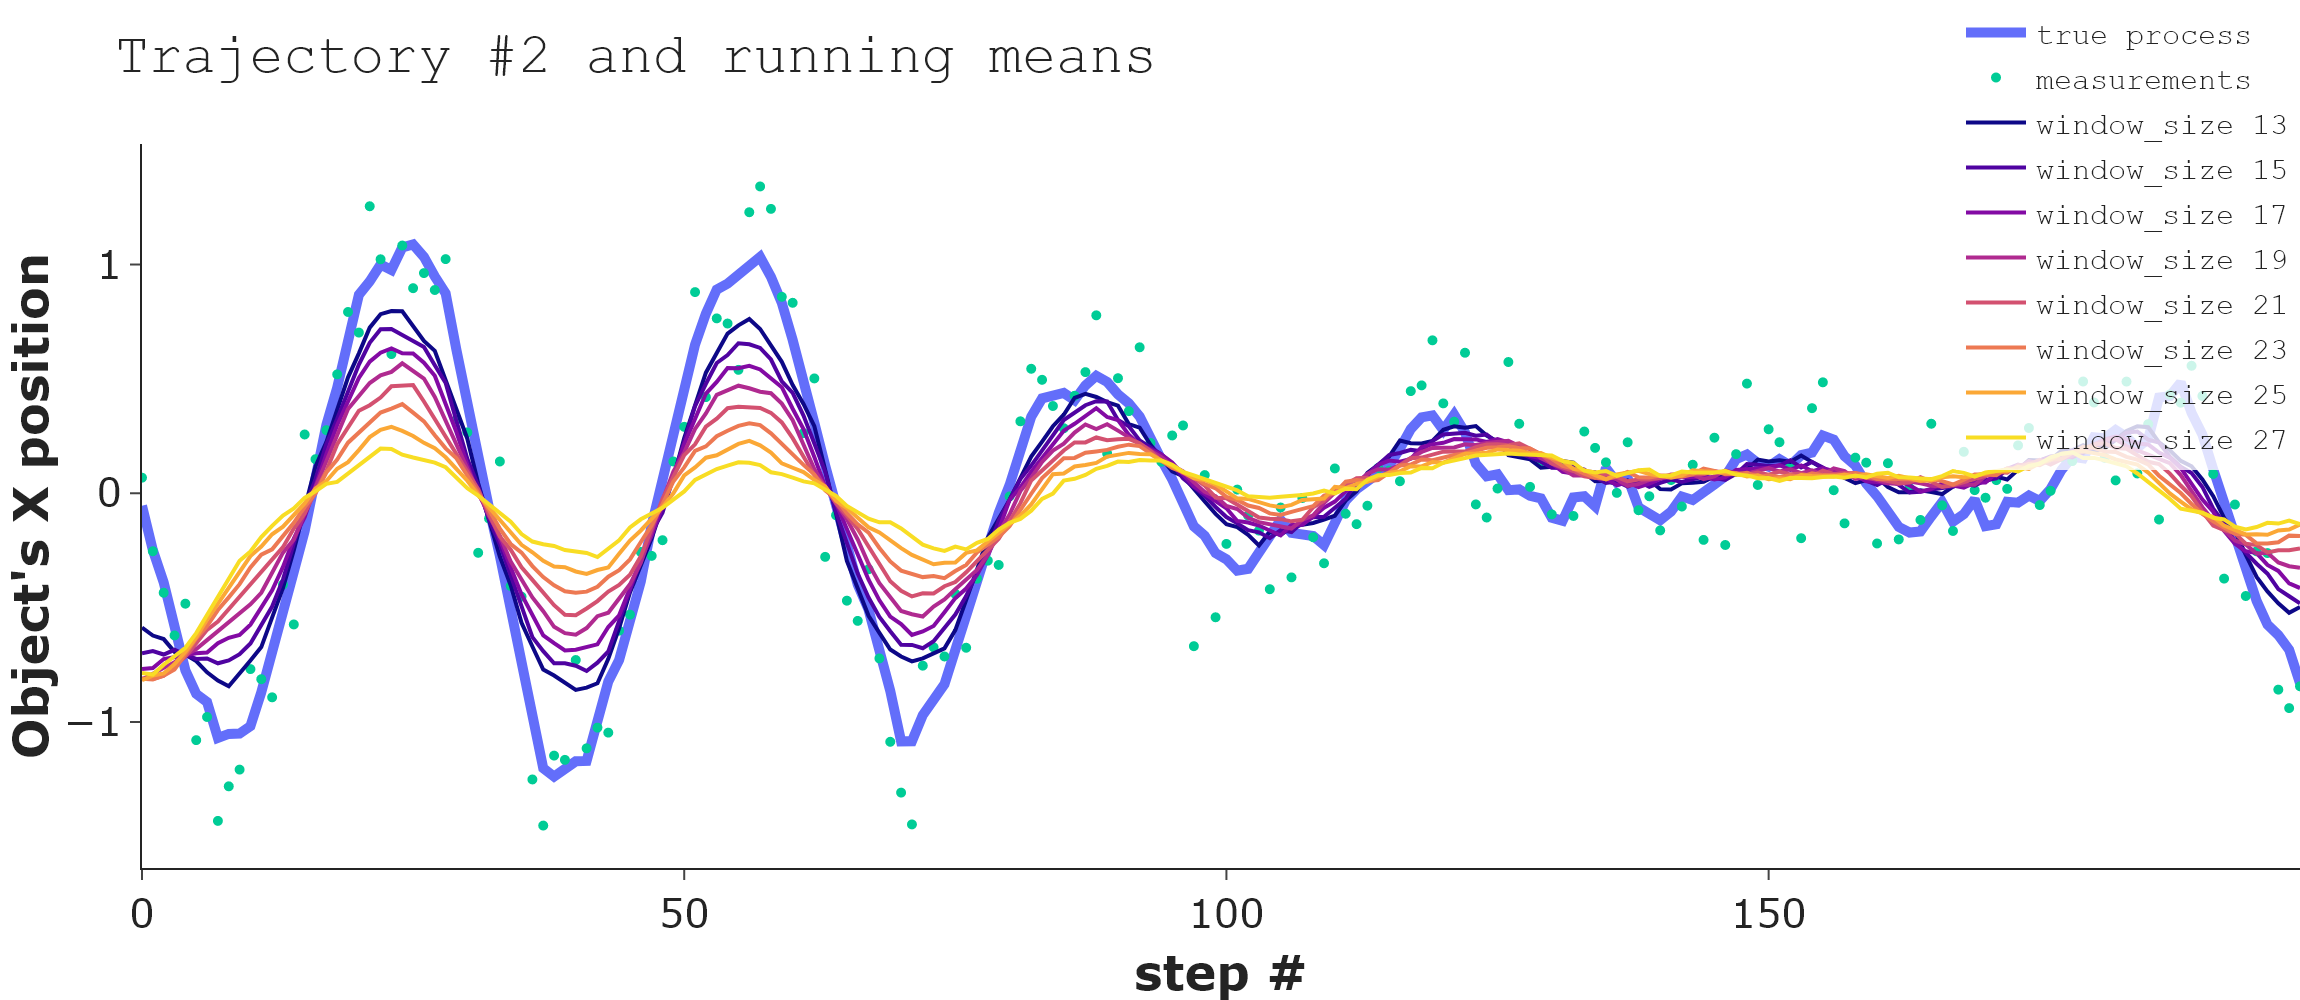

In [257]:
fig.write_image(f"Trajectory 2 and rolling means.png", format = 'png', width = 1150, height = 500, scale = 2)
Image("Trajectory 2 and rolling means.png")

The results are not very consistent here. Generated trajectories are usually quite sinusoidal and are very regular (regular oscillations of similar amplitude).<br>
We were not able to observe inverse oscillations with this set up.

Generally, the larger the rolling window is, the lower is the amplitude of oscillations.<br>
Also, if generated trajectory contains a combination high amplitude - low amplitude oscillations then the smoothed peak is usually shifted in the direction from high peak to lower peak (the larger the window - the larger the shift)

**Additional tests with higher sample size** revealed, that smoothing with rolling window = 32 "kills" oscillations and window_size > 32 lead to inverse oscillations.

Hence for window_size < T/2 smoothing produces no significant changes (a)
T/2 < window_size < 2*T leads to loss of oscillations
2*T < >

## Conclusions

Mirror edge for rolling mean and backwards smoothing for exponential smoothing are nice ways to remove some of the drawbacks of these smoothing methods

One very apparent drawback of both methods - if there is no "optimal" smoothing parameter, the choice of the exact value becomes a judgement call of a scientist working with data, which is not very good. Since the chosen empirical parameter (alpha or window_size) value is not defined rigorously.
Also in case of periodic data smoothing can significantly distort periodicity and lead to false conclusions if window_size is larger than half of the period